# **Kaggle Tabular Playground Series (September)**

## Preliminaries
### Review other notebooks

First review some of the top existing notebooks on Kaggle to get an idea of the competition. I will keep a running list of notebooks I view below. This is part of the exploration phase to better understand the competition landscape.

### Notes:
* Get some understanding of the libraries typically used in the competition
* In both train and test data sets, all features seem to be missing about 1.6% of the time. Will therefore need to deal with missing values.
* Interestingly, more missing data in a sample seems to correlate to higher chance of filing claim, according to notebooks which investigated that. Could be useful in feature engineering.
* First notebook's process: Intro -> Preparations -> Dataset overview -> Features -> Target -> Model
* Second notebook explores a variety of blindly engineered features. It is difficult because the features are anonymous. None of the engineered features in this notebook seem to change the AUC very much for the model used (LightGBM).
* Third notebook discusses working with large datasets which take up lots of memory. Key takeaways:
    * Load data using libraries like datatable, cuDF, or dask, not pandas. 
    * Reduce memory by casting each data into the smallest datatype possible.
    * Choose a fast data manipulation library as long as it is comfortable
    * Don't use entire dataset for experimentation and analysis
    * Choose a fast model like CatBoost, LightGBM, XGBoost (in that order). SKlearn models are slower only use CPU.

### References:
* https://www.kaggle.com/dwin183287/tps-september-2021-eda
* https://www.youtube.com/watch?v=KQ80oD_boBM
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* https://www.kaggle.com/dwin183287/tps-feb-2021-base-model-features-engineering
* https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro

## 1. Introduction

The Kaggle Tabular Playground Series is a monthly competition hosted by Kaggle involving completely tabular datasets. The purpose is to predict whether a customer will or will not file a claim (0 or 1). However, submitted predictions can be any continuous value from 0 to 1, representing a probability. Submissions will be scored by area under ROC curve.

#### What is the ROC curve?
The Reciever Operating Characteristic (ROC) Curve is function of the performance of a model at all classification thresholds. The function takes two parameters, True Positive Rate (TPR) and False Positive Rate (FPR). 

$$TPR = \dfrac{TP}{TP+FN}, \hspace{1cm} FPR = \dfrac{FP}{FP+TN}$$

A ROC curve plots TPR and FPR at all classification threshold values (from 1 to 0), so the graph starts at 0 or close to it (because the threshold is at 1), and then the curve gets larger, approaching 1 (because the threshold is clsoe to 0. Below is an example of an ROC curve taken from wikipedia https://en.wikipedia.org/wiki/Receiver_operating_characteristic

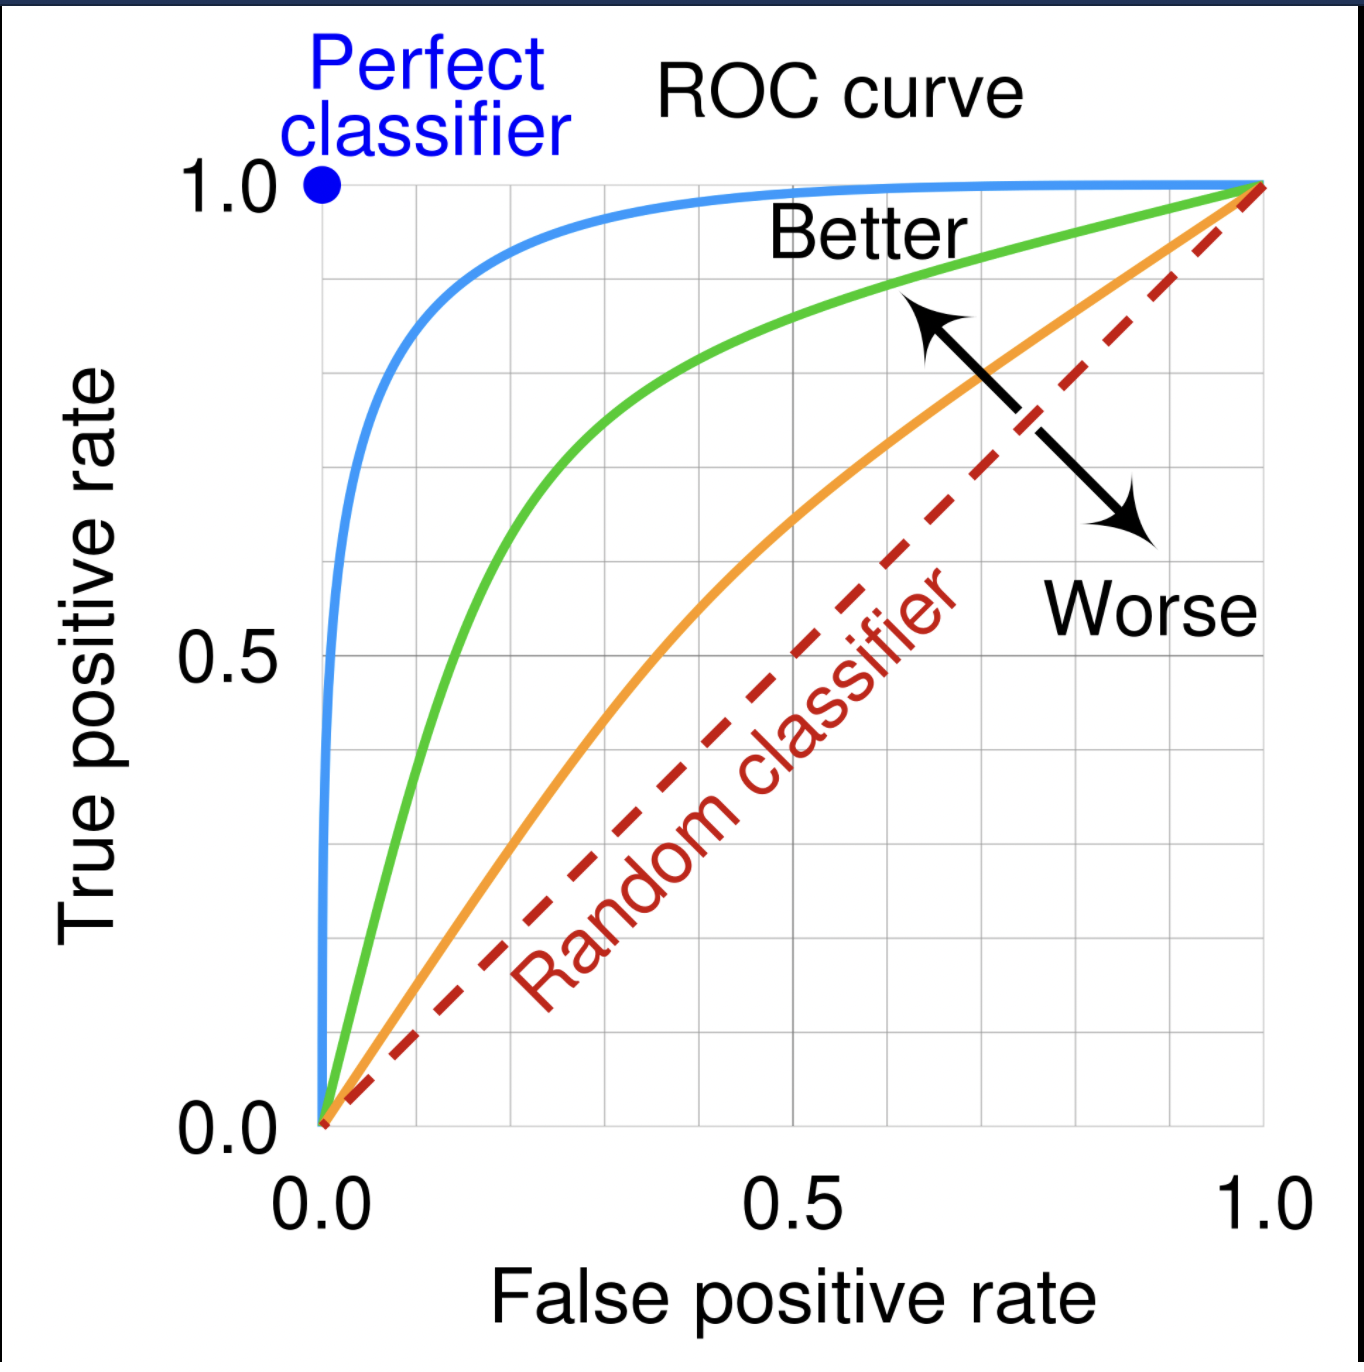

As can be seen by this image, the greater the AUC, the better your model, because it is predicting correctly at a high rate at any threshold value. The AUC can be a good metric because it is scale invariant and classification threshold invariant. For more information see https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.


### 2. Data and Preparation

The data provided is synthetic and anonymized, but based on a real data set generated using a CTGAN. Although the features are anonymized, they have properties relating to real-world features. Kaggle links this Github repo for more info on CTGAN https://github.com/sdv-dev/CTGAN. Faster data manipulation notebook: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro

In [ ]:
# import packages
import os
import numpy as np
import pandas as pd
import datatable as dt  # One notebook notes datatable as faster than pandas. See above for reference

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# setting up options
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('float_format', '{:f}'.format)
# warnings.filterwarnings('ignore')

# import datasets
train = dt.fread("./train.csv").to_pandas()
test = dt.fread("./test.csv").to_pandas()
#train_df = pd.read_csv('./train.csv')
#test_df = pd.read_csv('./test.csv')
#submission = pd.read_csv('./sample_solution.csv')

#### 2.1 Memory reduction
This kernel https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro?scriptVersionId=74269874&cellId=19 provides the following function for reducing the memory occupied by a given dataframe by recasting each data point into the smallest data structure necessary to contain it.

In [7]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
r_train = reduce_memory_usage(train, verbose=True)
r_test = reduce_memory_usage(test, verbose=True)

Mem. usage decreased to 262.19 Mb (0.0% reduction)
Mem. usage decreased to 134.60 Mb (0.0% reduction)


### 3. Data Exploration
Explore the data!

In [9]:
# Show example of train entries
r_train.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0,0.108582,0.004314,-37.5625,0.017365,0.289062,-10.250000,135.125,168900.0,3.992400e+14,...,-12.226562,1.748047,1.909180,-7.117188,4378.799805,1.209961,8.613400e+14,140.125,1.017578,True
1,1,0.100891,0.299561,11824.0000,0.276611,0.459717,-0.837402,1722.000,119810.0,3.874100e+15,...,-56.750000,4.167969,0.348145,4.140625,913.229980,1.246094,7.575100e+15,1861.000,0.283691,False
2,2,0.177979,-0.006981,907.5000,0.272217,0.459473,0.173218,2298.000,360650.0,1.224500e+13,...,-5.769531,1.204102,0.262939,8.132812,45119.000000,1.176758,3.218100e+14,3838.000,0.406982,True
3,3,0.152344,0.007259,780.0000,0.025177,0.519531,7.492188,112.500,259490.0,7.781400e+13,...,-34.843750,2.070312,0.796387,-16.343750,4952.399902,1.178711,4.533000e+12,4888.000,0.514648,True
4,4,0.116211,0.502930,-109.1250,0.297852,0.344971,-0.409424,2538.000,65332.0,1.907200e+15,...,-13.640625,1.530273,1.146484,-0.431152,3856.500000,1.483398,-8.991300e+12,NaN,0.230469,True


In [10]:
# Show basic statistics of train set
r_train.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,957919.000000,942672.000000,942729.000000,942428.0,942359.000000,942514.000000,942398.000000,942415.00,942546.00,9.426700e+05,...,942390.000000,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.00,942707.000000
mean,478959.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377158.75,1.805652e+15,...,NaN,NaN,NaN,NaN,NaN,63135.726562,NaN,4.276344e+16,NaN,NaN
std,276527.540591,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,345365.50,2.333172e+15,...,0.000000,0.000000,0.000000,0.000000,0.000000,92403.195312,0.000000,6.732441e+16,NaN,0.000000
min,0.000000,-0.149902,-0.019043,-9424.0,-0.082092,-0.006989,-12.789062,-224.75,-29843.00,-1.153300e+15,...,-0.042358,-105.875000,0.277100,-27.687500,-26.593750,-81977.000000,0.905273,-8.944400e+15,-415.25,-0.151245
25%,239479.500000,0.070251,0.282959,418.5,0.035095,0.240479,-1.121094,481.50,91209.00,1.153100e+13,...,0.113770,-28.812500,1.487305,-0.628906,-4.472656,2443.199951,1.146484,2.321100e+14,1306.00,0.276611
50%,478959.000000,0.090149,0.389160,1280.0,0.136963,0.327881,-0.380127,1446.00,289670.00,5.043050e+14,...,0.359131,-14.632812,1.662109,1.727539,0.885742,19479.000000,1.176758,1.327500e+16,3228.00,0.473389
75%,718438.500000,0.116516,0.458496,4444.0,0.297119,0.412842,0.921875,2496.00,560560.00,3.103100e+15,...,0.624512,-5.324219,2.521484,18.984375,6.839844,88488.000000,1.242188,5.278700e+16,6136.00,0.746094
max,957918.000000,0.415283,0.519043,39552.0,1.320312,0.554688,11.203125,5428.00,1913700.00,1.042400e+16,...,1.124023,1.613281,4.566406,217.875000,47.750000,526050.000000,1.886719,3.249900e+17,13152.00,2.744141


In [13]:
# Show basic structure of train set
print(f'Number of rows: {train.shape[0]};  Number of columns: {train.shape[1]}; No of missing values: {sum(train.isna().sum())}')

Number of rows: 957919;  Number of columns: 120; No of missing values: 1820782


In [14]:
# Show example of test entries
r_test.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
0,957919,0.165894,0.487061,1295.0,0.023102,0.319092,0.901855,573.5,3743.699951,2.705700e+12,...,0.162476,-22.187500,2.066406,0.430908,-10.742188,81606.0,1.194336,1.980400e+14,2017.0,0.463623
1,957920,0.129639,0.373535,1763.0,0.729004,0.332520,-1.262695,875.5,554370.000000,5.955700e+14,...,0.815430,-1.633789,1.573242,-1.071289,11.828125,90114.0,1.150391,4.388000e+16,6640.0,0.281250
2,957921,0.120178,0.445312,736.5,0.046143,0.296143,0.316650,2660.0,317140.000000,3.977800e+14,...,0.818359,-32.781250,2.136719,-1.931641,-3.281250,37739.0,1.155273,1.718100e+14,5844.0,0.137939
3,957922,0.054016,0.395996,996.0,0.859375,0.366699,-0.170654,386.5,325680.000000,-3.432200e+13,...,0.865723,-2.416016,1.519531,-0.011635,1.383789,26849.0,1.149414,2.138800e+17,6172.0,0.329102
4,957923,0.079956,-0.006920,10576.0,0.348389,0.450195,-1.841797,3028.0,428150.000000,9.291500e+11,...,0.251953,-18.625000,3.738281,0.756836,-4.941406,50336.0,1.249023,2.151300e+17,2250.0,0.337891


In [15]:
# Show basic statistics of test set
r_test.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,4.934740e+05,485662.000000,485583.000000,485679.00,485741.000000,485597.000000,485561.000000,485541.000,4.856190e+05,4.856560e+05,...,485461.000000,485701.000000,485585.000000,485449.000000,485718.000000,485532.000000,485497.000000,4.853910e+05,485711.00,485589.000000
mean,1.204656e+06,0.090454,NaN,NaN,NaN,NaN,-0.071594,NaN,3.768002e+05,1.808347e+15,...,NaN,NaN,NaN,NaN,NaN,63053.449219,NaN,4.283732e+16,NaN,NaN
std,1.424538e+05,0.043549,0.000000,NaN,0.000000,0.000000,0.000000,NaN,3.449886e+05,2.338151e+15,...,0.000000,0.000000,0.000000,0.000000,0.000000,92272.265625,0.000000,6.743966e+16,NaN,0.000000
min,9.579190e+05,-0.153198,-0.019058,-9440.00,-0.080688,-0.007008,-12.843750,-215.625,-2.780900e+04,-1.254900e+15,...,-0.042175,-104.750000,0.260986,-23.937500,-26.312500,-81381.000000,0.900879,-7.749400e+15,-416.25,-0.187012
25%,1.081287e+06,0.070190,0.283691,418.75,0.035156,0.240601,-1.119141,481.750,9.142400e+04,1.158000e+13,...,0.113281,-28.625000,1.488281,-0.624512,-4.476562,2474.875000,1.146484,2.317850e+14,1310.00,0.276855
50%,1.204656e+06,0.090149,0.388916,1278.00,0.137329,0.328125,-0.380127,1442.000,2.895900e+05,5.048250e+14,...,0.357910,-14.578125,1.663086,1.730469,0.911133,19429.000000,1.176758,1.330400e+16,3238.00,0.473877
75%,1.328024e+06,0.116516,0.458252,4420.00,0.297119,0.412842,0.923340,2490.000,5.596300e+05,3.106600e+15,...,0.622559,-5.316406,2.525391,18.953125,6.851562,88309.500000,1.242188,5.284700e+16,6156.00,0.745117
max,1.451392e+06,0.412842,0.520020,39840.00,1.310547,0.555664,11.046875,5412.000,1.906700e+06,1.048900e+16,...,1.109375,1.463867,4.570312,217.375000,47.312500,521540.000000,1.877930,3.239500e+17,13200.00,2.732422


In [16]:
# Show basic structure of test set
print(f'Number of rows: {test.shape[0]};  Number of columns: {test.shape[1]}; No of missing values: {sum(test.isna().sum())}')

Number of rows: 493474;  Number of columns: 119; No of missing values: 936218


#### 3.1 Missing Data 
Look further into missing data, since this could one of the few clues for engineering anonymous data

In [19]:
# Calculate percentage of data missing for each feature for both train and test.
# Start with train set
print(train.isna().mean()* 100)

# Also check test set
print(test.isna().mean()* 100)

## NOTE: ADD PRETTY GRAPHS LATER

id       0.000000
f1       1.591679
f2       1.585729
f3       1.617151
f4       1.624354
           ...   
f115     1.624250
f116     1.627382
f117     1.608382
f118     1.588026
claim    0.000000
Length: 120, dtype: float64
id      0.000000
f1      1.583062
f2      1.599071
f3      1.579617
f4      1.567053
          ...   
f114    1.609406
f115    1.616499
f116    1.637979
f117    1.573133
f118    1.597855
Length: 119, dtype: float64


We should also check how many values are missing in sample and get some basic statistics for that... could be a good feature to engineer down the line

In [23]:
# Calculate percentage of data missing for each sample for both train and test.
# Start with train set

## NOTE: ADD PRETTY GRAPHS LATER

train_samples_pct_missing = train.T.isna().mean()* 100
print(train.T.isna().count())

# Also check test set
test_samples_pct_missing = test.T.isna().mean()* 100
print(test.T.isna().count())

0         120
1         120
2         120
3         120
4         120
         ... 
957914    120
957915    120
957916    120
957917    120
957918    120
Length: 957919, dtype: int64
0         119
1         119
2         119
3         119
4         119
         ... 
493469    119
493470    119
493471    119
493472    119
493473    119
Length: 493474, dtype: int64


#### 3.2 Feature Distributions
We should also look at the distributions of each feature to get a better idea of their individual structure and also begin thinking about how we might want to tranform them to improve model performance.